## Load Libraries

In [ ]:
# Install Tensorflow Object Detection 
if os.name=='posix':  
    !apt-get install protobuf-compiler
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install . 
    
if os.name=='nt':
    url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
    wget.download(url)
    !move protoc-3.15.6-win64.zip {paths['PROTOC_PATH']}
    !cd {paths['PROTOC_PATH']} && tar -xf protoc-3.15.6-win64.zip
    os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(paths['PROTOC_PATH'], 'bin'))   
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf2\\setup.py setup.py && python setup.py build && python setup.py install
    !cd Tensorflow/models/research/slim && pip install -e .

In [1]:
import os
import cv2
# import imutils
import math
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

import easyocr
import requests

CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}



import object_detection
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

from dotenv import load_dotenv

load_dotenv()
import smtplib
import imghdr
from email.message import EmailMessage
from email.mime.text import MIMEText
from email.mime.image import MIMEImage
from email.mime.multipart import MIMEMultipart





/home/krypc-sharath/autoPlate/ANPR/anprsys/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import tensorflow as tf

In [3]:
# Setup for sending autmatic mail

EMAIL_ADDRESS = os.getenv('EMAIL_USER')
EMAIL_PASSWORD = os.getenv('EMAIL_PASSWORD')

print(EMAIL_PASSWORD,EMAIL_ADDRESS)

project_id = '2HrvvsBjSJqiPGaHpxYzK2XxvYF'
secret_proj = 'e92f93a65b71766e1befb47b87a818e7'


#infura ipfs


contacts = ['mushtaq.akram@gmail.com','sharathadm97@gmail.com']

def SendMail(ImgFileName,from_address,to_address,UserName,UserPassword,payload,ipfs_hash):
    with open(ImgFileName, 'rb') as f:
        img_data = f.read()

    Server = 'smtp.gmail.com'
    Port = 587
    msg = MIMEMultipart()
    msg['Subject'] = 'License Plate Details'
    msg['From'] = EMAIL_ADDRESS
    msg['To'] = contacts[1]

    text = MIMEText("The following license text has been detected. \n {} \nIPFS HASH: {}\n The IPFS link is:\n https://ipfsbrowser.com/?hash={}".format(payload,ipfs_hash,ipfs_hash))
    msg.attach(text)
    image = MIMEImage(img_data, name=os.path.basename(ImgFileName))
    msg.attach(image)

    s = smtplib.SMTP(Server, Port)
    s.ehlo()
    s.starttls()
    s.ehlo()
    s.login(UserName, UserPassword)
    s.sendmail(from_address, to_address[1], msg.as_string())
    s.quit()

xyz abc


In [4]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])
detection_threshold = 0.8

## Load Pre-Trained Model

In [6]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-11')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

In [55]:

def PlateDetection(IMAGE_PATH):
    img = cv2.imread(IMAGE_PATH)
    image_np = np.array(img)

    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)

    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)

    plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
    plt.show()

    image = image_np_with_detections
    scores = list(filter(lambda x: x> detection_threshold, detections['detection_scores']))
    boxes = detections['detection_boxes'][:len(scores)]
    classes = detections['detection_classes'][:len(scores)]

    width = image.shape[1]
    height = image.shape[0]

    if(boxes.size>0):
        print("Plates detected!")
    else:
        print("No plates detected!")

    # Apply ROI filtering and OCR
    for idx, box in enumerate(boxes):
        #print(box)
        roi = box*[height, width, height, width]
        #print(roi)
        region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
        
        reader = easyocr.Reader(['en'])
        ocr_result = reader.readtext(region)
        cv2.imwrite('./RESULTS/plate_image.png',region)
        cv2.imwrite('./RESULTS/car_image.png',image)
        if (ocr_result):
            detected_text = ocr_result[0][1]
            confidence_level = ocr_result[0][2]*100
            print(detected_text,confidence_level)
            base_dir = os.getcwd()
            results_dir = base_dir+'RESULTS/plate_image.png'

            #Send result as email
            plate_image = './RESULTS/plate_image.png'
            files = {
                'file': plate_image
            }
            response = requests.post('https://ipfs.infura.io:5001/api/v0/add', files=files, auth=(project_id,secret_proj))
            result_ipfs = response.json()
            print(result_ipfs)
            ipfs_hash = result_ipfs['Hash']
            SendMail(plate_image,EMAIL_ADDRESS,contacts,EMAIL_ADDRESS,EMAIL_PASSWORD,detected_text,ipfs_hash)
            print("Mail has been sent!")
        else:
            print("Could not detect text in license plate.")
        plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))


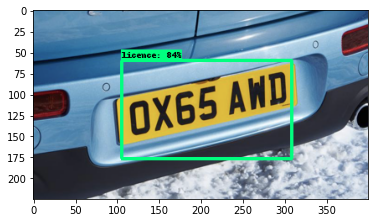

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


Plates detected!
AND 98.2448861957801
Mail has been sent!


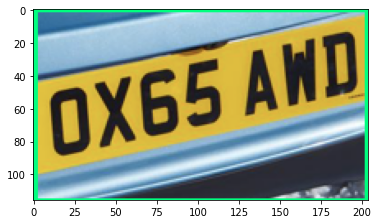

In [64]:
# For detecting plate4s from a single image.
#IMAGE_PATH = "./RESULTS/results.png"
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test', 'Cars418.png')

PlateDetection(IMAGE_PATH)

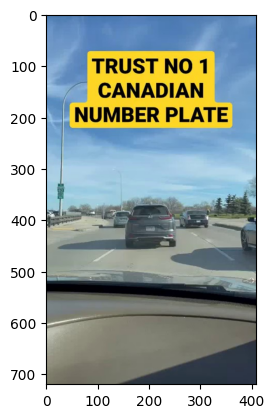

No plates detected!


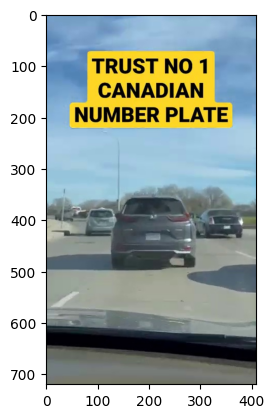

No plates detected!


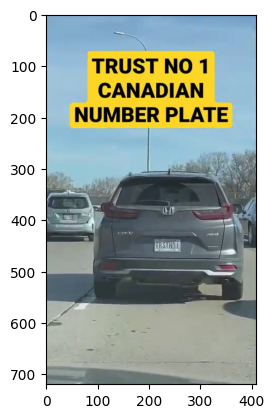

No plates detected!


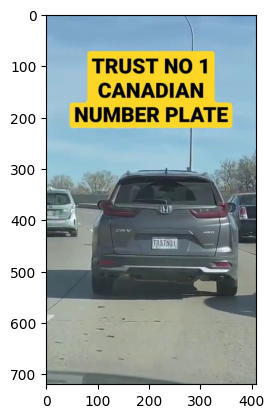

No plates detected!


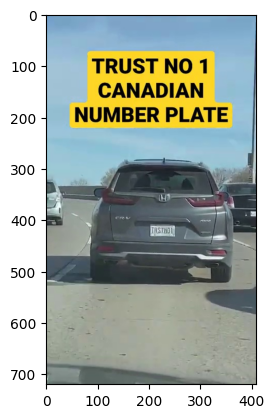

No plates detected!


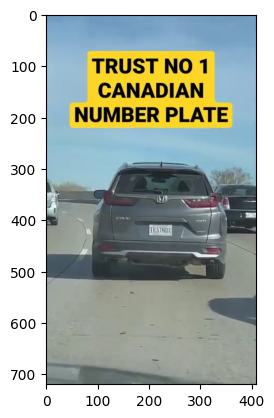

No plates detected!


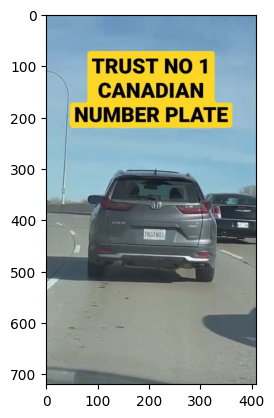

No plates detected!


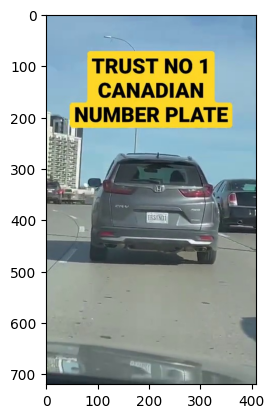

No plates detected!
Done!


In [30]:
# video Analysis
result_path = "./Videos/"

count = 0
videoFile = "./Videos/car.mp4"
cap = cv2.VideoCapture(videoFile)   # capturing the video from the given path
frameRate = cap.get(5) #frame rate
x=1
while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):
        filename ="frame%d.jpg" % count;count+=1
        cv2.imwrite(result_path+filename, frame)
        PlateDetection(result_path+filename)
cap.release()

print ("Done!")